In [22]:
import argparse
import gdown
import cv2
import numpy as np
import os
import sys
sys.path.append(sys.path[0]+"/tracker")
sys.path.append(sys.path[0]+"/tracker/model")
from track_anything import TrackingAnything
from track_anything import parse_augment
import requests
import json
import torchvision
import torch 
from tools.painter import mask_painter
import psutil
import time
try: 
    from mmcv.cnn import ConvModule
except:
    os.system("mim install mmcv")
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils

In [3]:
SAM_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
xmem_checkpoint = "./checkpoints/XMem-s012.pth"
e2fgvi_checkpoint = "./checkpoints/E2FGVI-HQ-CVPR22.pth"
args = {}
model = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)

Initializing BaseSegmenter to cuda:0
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
load pretrained SPyNet...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


In [5]:
ovis_anotations = 'D:/HADA/data/OVIS/annotations/'
ovis_images = 'D:/HADA/data/OVIS/train_images/'

In [33]:
def cargarDatos(ruta_ann):
    with open(ruta_ann + 'annotations_train.json') as f:
        annotationsTrain = json.load(f)

    with open(ruta_ann + 'annotations_valid.json') as f:
        annotationsValid = json.load(f)

    with open(ruta_ann + 'annotations_test.json') as f:
        annotationsTest = json.load(f)

    clases = annotationsTrain['categories']
    vidTrain = annotationsTrain['videos']
    annTrain = annotationsTrain['annotations']
    vidValid = annotationsValid['videos']
    annValid = annotationsValid['annotations']
    vidTest = annotationsTest['videos']
    annTest = annotationsTest['annotations']

    return clases, vidTrain, annTrain, vidValid, annValid, vidTest, annTest

clases, vidTrain, annTrain, vidValid, annValid, vidTest, annTest = cargarDatos(ovis_anotations) 

In [17]:
first_video_folder = vidTrain[0]['file_names'][0].split('/')[0]

(-0.5, 1919.5, 885.5, -0.5)

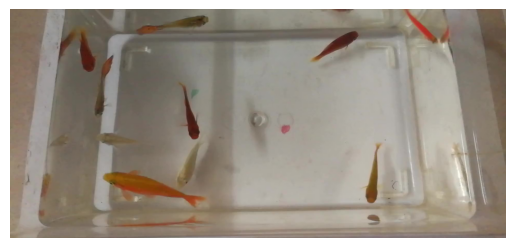

In [20]:
# Lee una imagen y la muestra en una ventana
img = cv2.imread(ovis_images + first_video_folder +'/img_0000001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

In [23]:
def annToRLE(ann, frameId):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    h, w = ann['height'], ann['width']
    segm = ann['segmentations'][frameId]
    if type(segm) == "list":
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm['counts']) == "list":
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle


def annToMask(ann, frameId):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(ann, frameId)
    m = maskUtils.decode(rle)
    return m


def combineMasks(masks, width, height):
    # Crear una matriz vacía para la máscara combinada
    combined = np.zeros((height, width), dtype=np.uint8)

    # Combinar las máscaras en la matriz vacía
    for mask in masks:
        combined += mask  # Sumar la máscara a la máscara combinada

    # Aplicar umbral para obtener una única máscara binaria
    combined = np.where(combined > 0, 1, 0)
    return combined

In [25]:
colors = [
    (255, 0, 0),    # Rojo
    (0, 255, 0),    # Verde
    (0, 0, 255),    # Azul
    (255, 255, 0),  # Amarillo
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cian
    (128, 0, 0),    # Marrón oscuro
    (0, 128, 0),    # Verde oscuro
    (0, 0, 128),    # Azul oscuro
    (128, 128, 0),  # Amarillo oscuro
    (128, 0, 128),  # Magenta oscuro
    (0, 128, 128),  # Cian oscuro
    (255, 128, 0),  # Naranja
    (128, 255, 0),  # Lima
    (255, 0, 128),  # Rosa
    (128, 0, 255),  # Violeta
    (0, 255, 128),  # Turquesa
    (0, 128, 255),  # Azul claro
    (255, 128, 128), # Rosa claro
    (128, 255, 128)  # Verde claro
]

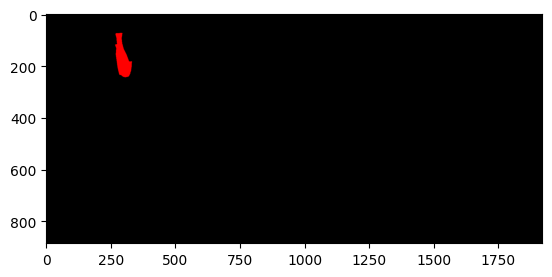

In [40]:
ann = []
video = vidTrain[0]
for a in annTrain:
    if a['video_id'] == video['id']:
        ann.append(a)
        break
    else: continue

mask = annToMask(ann[0], 0)
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
colored_mask[:, :, 0] = mask * colors[0][0]
colored_mask[:, :, 1] = mask * colors[0][1]
colored_mask[:, :, 2] = mask * colors[0][2]
plt.imshow(colored_mask)

In [7]:
annTrain[0]

{'length': 1,
 'category_id': 19,
 'video_id': 1,
 'iscrowd': 0,
 'id': 1,
 'height': 886,
 'width': 1920,
 'segmentations': [{'size': [886, 1920],
   'counts': 'YTW71dk04cN0nVO3nh02mVO1FOZh04mWO0ZO?bh0EPXOW1ig0TOlWOS1mg0VOiWOR1Ph0b1H7I6J4L5K4L4L4L3M2M2O000000001O001O\\KhYOk3Wf0oKXZOi3he0oKfZOk3ef0M4M3M2M4L3N1N2N2N2O1N2N2N2M3N2N2N3M3L3N3M3M2M4M3L3M2M2N3M2N2N1K6O1L4H8BWUOHPk0OknlZ1'},
  {'size': [886, 1920],
   'counts': 'PcZ72ck05[UO8Ui0J_VOl0Ui0WO_VOV1]i0f0fNoMfXOe2df0jMnXOY2nf0VNeXOk1Yg0[1M4M3N3L3N1N10000O0100O10O100001O1O2N1O2N3M6J7H9G6J3M4M2M3M3M3M3M3L4M3M3M3M2M3N1O2M2M4M1N2O0O2M2L5eNPVOk0Tj0UOnUOg0Uj0WOnUOh0Rj0WOQVOf0oi0YOTVOb0Pj0]OYVO5mi0IUXkZ1'},
  {'size': [886, 1920],
   'counts': 'PcZ73o05\\i01XVO?`i0ETVOj0ei0i0iNWNVXOm1bg0`NVXOc1bg0iNVXOl1Sg0_NdXOc1Xg0b1L5K3M3M2O1O1O00O2O000O10000O4M4L=B4M4K4M2M3N3L3N3L3M4M2M2N1O1N2O1O1O3M4K4M4L4L4K3L4M00J6N12O8G;E5K5K5J6@kimZ1'},
  {'size': [886, 1920],
   'counts': 'e^[76P1;Ph0BkWO<E>[h0\\OlWO7^Oj0ah0VOmWOa1og0dNmWO`1mg0iNmWOP2Xg0YN`XOh1]g